In [1]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [2]:
# GLOBAL SETTINGS

# Directories
model_dataDir = 'DATA/MODELDATA/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time
START = 2020
END = 2022



#Helpers
idx = pd.IndexSlice



In [3]:
# Helper Functions
'''
def get_trade_prices(tickers, start, stop):
    prices = model_mdf
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'Open']
    return (prices
            .unstack('Coin')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))
'''

def get_trade_prices(start, stop):
    model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
    model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
    model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
    model_mdf.set_index(['Dates', 'Coin'], inplace=True)
    model_mdf = model_mdf.loc[:,'Open']
    #model_mdf = model_mdf.loc[idx[tickers, str(START):str(END)], 'Open']
    prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')
    
    return prices



def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()


def get_factor(predictions):
    return (predictions.unstack('Coin')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='Dates')
            .sort_index())    

In [4]:
# Load the Model Results Data
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_scores = pd.read_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Load the OHLV Price data
#model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
#model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
#model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
#model_mdf.set_index(['Dates', 'Coin'], inplace=True)
#model_mdf = model_mdf.loc[:,'Open':'Volume']
#prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')

In [5]:
# Now we will check the Alpha and Beta metrics of the signals found by our models in the prior step

In [6]:
# From Linear Regression
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

Dates                      Coin                 
2020-02-01 00:00:00+00:00  algorand                 0.025134
                           arweave                  0.016334
                           basic-attention-token    0.016569
                           binancecoin             -0.008778
                           bitcoin                 -0.004959
dtype: float64

In [7]:
#tickers = lr_factor.index.get_level_values('Coin').unique()

In [8]:
trade_prices = get_trade_prices(2020, 2022)
#trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 2020-01-01 00:00:00+00:00 to 2022-01-14 00:00:00+00:00
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   algorand               744 non-null    float64
 1   arweave                744 non-null    float64
 2   basic-attention-token  744 non-null    float64
 3   binancecoin            744 non-null    float64
 4   bitcoin                744 non-null    float64
 5   bitcoin-cash           744 non-null    float64
 6   bitcoin-cash-sv        744 non-null    float64
 7   bittorrent-2           744 non-null    float64
 8   cardano                744 non-null    float64
 9   chainlink              744 non-null    float64
 10  cosmos                 744 non-null    float64
 11  crypto-com-chain       744 non-null    float64
 12  dash                   744 non-null    float64
 13  decentraland           744 non-null    float64
 14  dogecoin 

In [9]:
#print(len(trade_prices.columns))

41


In [10]:
trade_prices.head()

Coin,algorand,arweave,basic-attention-token,binancecoin,bitcoin,bitcoin-cash,bitcoin-cash-sv,bittorrent-2,cardano,chainlink,...,monero,okb,ripple,stellar,terra-luna,tezos,theta-token,tron,vechain,zcash
Dates,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,0.217110,0.652953,0.190072,13.522027,7139.044338,201.799270,95.251893,0.000280,0.032875,1.784257,...,45.668221,2.583228,0.191127,0.044894,0.217308,1.351242,0.085440,0.013090,0.005313,27.657228
2020-01-02 00:00:00+00:00,0.225794,0.698436,0.185653,13.579740,7196.883716,203.727639,96.466791,0.000283,0.033663,1.780386,...,48.339400,2.612412,0.190122,0.045167,0.204538,1.272692,0.085352,0.013154,0.005259,27.393856
2020-01-03 00:00:00+00:00,0.228031,0.668637,0.186281,13.650140,7320.309525,221.811173,104.624500,0.000289,0.033864,1.791668,...,50.422485,2.619287,0.192036,0.045401,0.231951,1.277193,0.088620,0.013391,0.005350,28.276526
2020-01-04 00:00:00+00:00,0.234223,0.597861,0.190017,13.972162,7448.688305,223.863172,110.612056,0.000290,0.034543,1.804323,...,51.035368,2.678726,0.194730,0.045771,0.239527,1.268082,0.092812,0.013656,0.005580,30.396363
2020-01-05 00:00:00+00:00,0.233386,0.722573,0.191317,14.380112,7520.122401,236.732977,115.716651,0.000296,0.035271,1.838128,...,55.979012,2.711035,0.196440,0.046401,0.234815,1.268031,0.099747,0.013867,0.005519,31.452828


In [11]:
# Get forward returns and Quantiles
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 7, 14, 30))
lr_factor_data.info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28042 entries, (Timestamp('2020-02-01 00:00:00+0000', tz='UTC', freq='C'), 'algorand') to (Timestamp('2021-12-15 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               28042 non-null  float64
 1   7D               28042 non-null  float64
 2   14D              28042 non-null  float64
 3   30D              28042 non-null  float64
 4   factor           28042 non-null  float64
 5   factor_quantile  28042 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.283355,0.082440,-0.016816,0.029610,6154,21.945653
2,-0.191024,0.094506,-0.001054,0.025101,5472,19.513587
3,-0.172748,0.111710,0.006195,0.024782,5472,19.513587
4,-0.153456,0.128119,0.013442,0.024992,5472,19.513587
5,-0.103364,0.349697,0.028356,0.028889,5472,19.513587


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,1.748,0.776,0.405,-0.340
beta,-0.008,0.137,0.287,0.812
Mean Period Wise Return Top Quantile (bps),36.966,42.588,48.315,78.969
Mean Period Wise Return Bottom Quantile (bps),-36.958,-30.422,-30.984,-47.649
Mean Period Wise Spread (bps),73.923,70.673,68.332,54.453


Information Analysis


,1D,7D,14D,30D
IC Mean,0.050,0.076,0.094,0.125
IC Std.,0.212,0.199,0.203,0.228
Risk-Adjusted IC,0.238,0.383,0.463,0.551
t-stat(IC),6.223,10.010,12.097,14.401
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.069,-0.041,-0.044,0.116
IC Kurtosis,-0.194,-0.334,-0.023,-0.300


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.387,0.623,0.704,0.755
Quantile 2 Mean Turnover,0.605,0.757,0.785,0.790
Quantile 3 Mean Turnover,0.643,0.766,0.788,0.791
Quantile 4 Mean Turnover,0.601,0.740,0.777,0.800
Quantile 5 Mean Turnover,0.389,0.635,0.704,0.783


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.678,0.297,0.145,0.015


<Figure size 432x288 with 0 Axes>

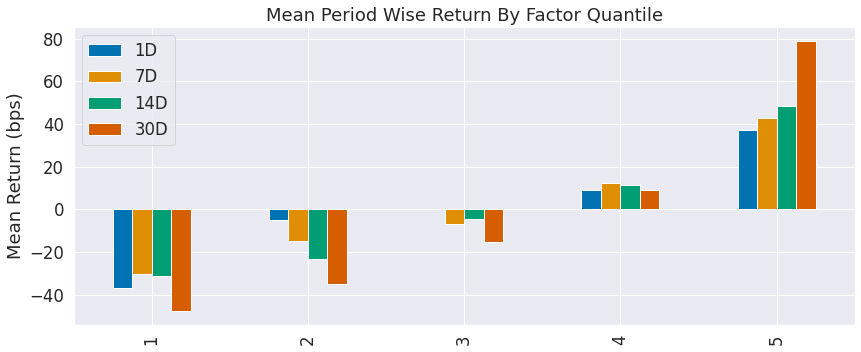

In [12]:
create_summary_tear_sheet(lr_factor_data);

In [13]:
# From Ridge
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [14]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

Dates                      Coin                 
2020-02-01 00:00:00+00:00  algorand                 0.007555
                           arweave                  0.011773
                           basic-attention-token    0.000475
                           binancecoin             -0.014819
                           bitcoin                 -0.016480
dtype: float64

In [15]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 7, 14, 30))
ridge_factor_data.info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28042 entries, (Timestamp('2020-02-01 00:00:00+0000', tz='UTC', freq='C'), 'algorand') to (Timestamp('2021-12-15 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               28042 non-null  float64
 1   7D               28042 non-null  float64
 2   14D              28042 non-null  float64
 3   30D              28042 non-null  float64
 4   factor           28042 non-null  float64
 5   factor_quantile  28042 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.648669e+14,3.301341e-02,-3.696058e+11,5.335232e+12,6154,21.945653
2,-1.762428e+13,4.215589e-02,-4.138344e+10,6.607308e+11,5472,19.513587
3,-9.254706e+11,4.943084e+12,1.822404e+10,2.691363e+11,5472,19.513587
4,-3.555006e-02,1.082207e+13,5.828480e+10,6.996180e+11,5472,19.513587
5,-2.683243e-02,2.086672e+13,1.060812e+11,1.264287e+12,5472,19.513587


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,2.240,0.935,0.474,-0.159
beta,0.004,0.150,0.305,0.675
Mean Period Wise Return Top Quantile (bps),53.548,45.147,50.785,77.468
Mean Period Wise Return Bottom Quantile (bps),-29.835,-30.865,-31.173,-42.448
Mean Period Wise Spread (bps),83.383,73.654,67.753,53.640


Information Analysis


,1D,7D,14D,30D
IC Mean,0.055,0.082,0.099,0.131
IC Std.,0.213,0.201,0.205,0.230
Risk-Adjusted IC,0.261,0.407,0.481,0.569
t-stat(IC),6.815,10.642,12.589,14.878
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.099,-0.027,0.009,0.178
IC Kurtosis,-0.091,-0.192,-0.135,-0.439


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.394,0.598,0.670,0.736
Quantile 2 Mean Turnover,0.600,0.741,0.776,0.784
Quantile 3 Mean Turnover,0.642,0.758,0.783,0.784
Quantile 4 Mean Turnover,0.606,0.736,0.758,0.788
Quantile 5 Mean Turnover,0.396,0.633,0.691,0.757


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.648,0.324,0.198,0.053


<Figure size 432x288 with 0 Axes>

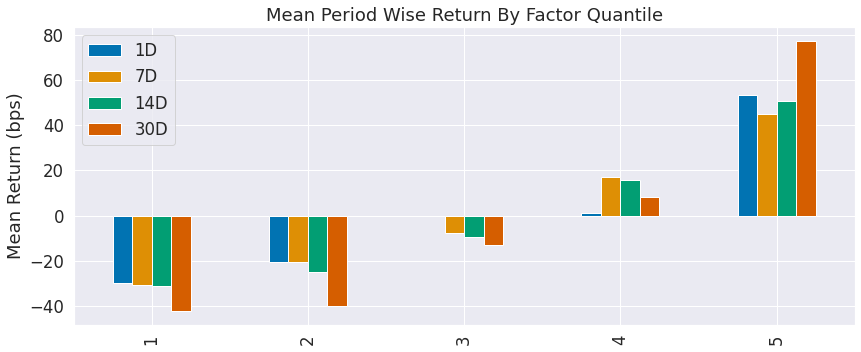

In [16]:
create_summary_tear_sheet(ridge_factor_data);

In [17]:
# From Lasso
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [18]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

Dates                      Coin                 
2020-02-01 00:00:00+00:00  algorand                 0.005298
                           arweave                  0.016752
                           basic-attention-token   -0.000091
                           binancecoin             -0.020124
                           bitcoin                 -0.014471
dtype: float64

In [19]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 7, 14, 30))
lasso_factor_data.info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28042 entries, (Timestamp('2020-02-01 00:00:00+0000', tz='UTC', freq='C'), 'algorand') to (Timestamp('2021-12-15 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               28042 non-null  float64
 1   7D               28042 non-null  float64
 2   14D              28042 non-null  float64
 3   30D              28042 non-null  float64
 4   factor           28042 non-null  float64
 5   factor_quantile  28042 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.007397e+14,5.334459e-02,-2.258427e+11,3.260023e+12,6154,21.945653
2,-1.076908e+13,6.195830e-02,-2.528680e+10,4.037307e+11,5472,19.513587
3,-5.654965e+11,3.020405e+12,1.113556e+10,1.644522e+11,5472,19.513587
4,-1.141143e-01,6.612681e+12,3.561415e+10,4.274922e+11,5472,19.513587
5,-8.235611e-02,1.275033e+13,6.481948e+10,7.725259e+11,5472,19.513587


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,2.211,0.897,0.458,-0.191
beta,-0.002,0.142,0.305,0.707
Mean Period Wise Return Top Quantile (bps),40.131,48.148,54.140,79.083
Mean Period Wise Return Bottom Quantile (bps),-34.823,-30.050,-32.192,-43.011
Mean Period Wise Spread (bps),74.955,75.712,72.310,62.786


Information Analysis


,1D,7D,14D,30D
IC Mean,0.053,0.077,0.090,0.129
IC Std.,0.216,0.202,0.210,0.234
Risk-Adjusted IC,0.245,0.381,0.430,0.550
t-stat(IC),6.409,9.977,11.248,14.385
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.109,-0.110,-0.099,0.126
IC Kurtosis,0.051,-0.070,0.023,-0.503


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.411,0.628,0.696,0.747
Quantile 2 Mean Turnover,0.617,0.758,0.782,0.789
Quantile 3 Mean Turnover,0.643,0.772,0.782,0.787
Quantile 4 Mean Turnover,0.612,0.744,0.769,0.778
Quantile 5 Mean Turnover,0.419,0.654,0.703,0.759


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.619,0.258,0.146,0.03


<Figure size 432x288 with 0 Axes>

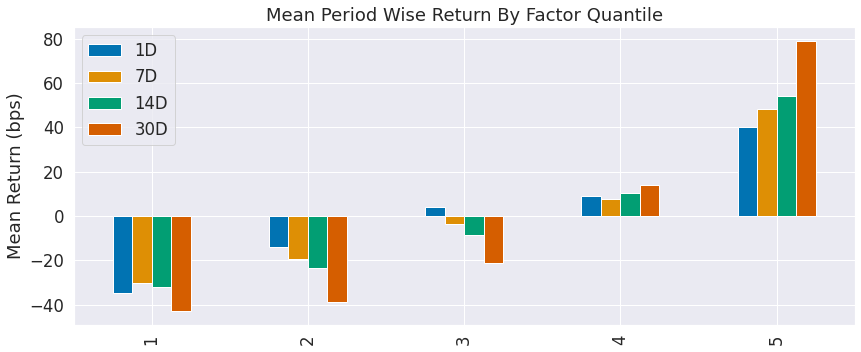

In [20]:
create_summary_tear_sheet(lasso_factor_data);